In [15]:
import requests

## Setup variables

In [19]:
api_key = '...'

In [20]:
query_id = '...'

In [21]:
sql_body = """with
  mints_and_burns as (
    select
      block_timestamp,
      chain,
      case
        when from_address = '0x0000000000000000000000000000000000000000' then amount
        when to_address = '0x0000000000000000000000000000000000000000' then - amount
      end as amount,
      case
        when from_address = '0x0000000000000000000000000000000000000000' then raw_amount
        when to_address = '0x0000000000000000000000000000000000000000' then - raw_amount
      end as raw_amount
    from
      crosschain.stablecoin.transfers
    where
      1 = 1
      and base_asset in ('usdt')
      and chain not in ('solana', 'tron') -- For EVM chains
      and (
        to_address = '0x0000000000000000000000000000000000000000'
        or from_address = '0x0000000000000000000000000000000000000000'
      )
  )
select
  date_trunc ('day', block_timestamp) as date,
  chain,
  sum(amount) as amt,
  sum(raw_amount) as raw_amt
from
  mints_and_burns
group by
  1,
  2"""

## Create a query run

In [36]:
request_body = {
    "parameters": {
        "sql": sql_body
    },
    "run_config": {}
}
request_headers = {
    "X-API-KEY": api_key
}
run_id_response = requests.post(f'https://api.allium.so/api/v1/explorer/queries/{query_id}/run-async', json=request_body, headers=request_headers)
run_id_json = run_id_response.json()
run_id = run_id_json.get('run_id')
print('run_id:', run_id)

run_id: mHTuTTIPy4CYBw3dXult


## Poll the query run result

In [50]:
import time

In [53]:
status = 'started'
while True:
    status_resp = requests.get(f'https://api.allium.so/api/v1/explorer/query-runs/{run_id}/status', headers=request_headers)
    status = status_resp.text.replace('"', '')
    print('status:', status)
    if status not in ['started', 'queued', 'running']:
        break
    time.sleep(3) # to prevent being rate limited

status: success


## Get the results on success

In [60]:
results_resp = requests.get(f'https://api.allium.so/api/v1/explorer/query-runs/{run_id}/results', headers=request_headers)
results = results_resp.json()
print('result object keys:', [k for k in results.keys()])

results_data = results['data']
print('result data length:', len(results_data))

result object keys: ['sql', 'data', 'meta', 'queried_at']
result data length: 6920


In [61]:
results_data

[{'date': '2023-12-10T00:00:00',
  'chain': 'ethereum',
  'amt': 1000.0,
  'raw_amt': 1000000000.0},
 {'date': '2024-03-19T00:00:00',
  'chain': 'polygon',
  'amt': 4906473.752462001,
  'raw_amt': 4906473752462.0},
 {'date': '2022-04-09T00:00:00',
  'chain': 'polygon',
  'amt': 217.96453499999689,
  'raw_amt': 217964535.0},
 {'date': '2023-10-18T00:00:00',
  'chain': 'polygon',
  'amt': 1387969.0813069998,
  'raw_amt': 1387969081307.0},
 {'date': '2022-04-15T00:00:00',
  'chain': 'arbitrum',
  'amt': 282987.57836,
  'raw_amt': 282987578360.0},
 {'date': '2022-03-13T00:00:00',
  'chain': 'arbitrum',
  'amt': 197554.152254,
  'raw_amt': 197554152254.0},
 {'date': '2022-11-12T00:00:00',
  'chain': 'avalanche',
  'amt': -560805.2303950001,
  'raw_amt': -560805230395.0},
 {'date': '2021-08-03T00:00:00',
  'chain': 'avalanche',
  'amt': 239474.28649899998,
  'raw_amt': 239474286499.0},
 {'date': '2021-12-08T00:00:00',
  'chain': 'avalanche',
  'amt': 16673389.769612,
  'raw_amt': 16673389769

## Convert to Dataframe

In [64]:
import pandas as pd

In [71]:
df = pd.DataFrame.from_records(results_data)
df = df.sort_values(by='date')

<Axes: xlabel='date'>

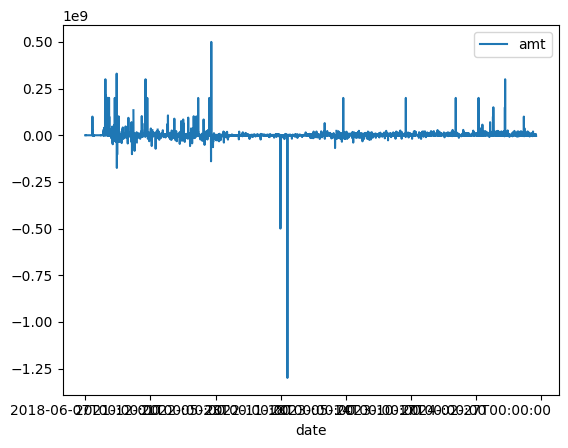

In [72]:
df.plot.line(x='date', y='amt')